# RAG (main)

## Dependencies

In [43]:
import os
from dotenv import load_dotenv
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
import hnswlib
import numpy as np
from langchain.vectorstores import VectorStore
from langchain_community.document_loaders import PyPDFLoader
from langchain_core.vectorstores import InMemoryVectorStore
import pandas as pd
import spacy
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

## Environment Setup

In [44]:
# load the environment variables
load_dotenv() 

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_ENDPOINT"] = os.getenv("LANGCHAIN_ENDPOINT")
os.environ["LANGCHAIN_PROJECT"] = os.getenv("LANGCHAIN_PROJECT")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

## Retrieve PDFs (target)

Things to Consider
- chunking level
- data cleaning
- meta data

In [45]:
# PDFs (target)
pdf_urls = [
    "https://www.ph.emb-japan.go.jp/files/100508281.pdf", # TOURISM
    "https://www.ph.emb-japan.go.jp/files/100508282.pdf", # BUSINESS, CONFERENCE or CULTURAL EXCHANGE, etc.
    "https://www.ph.emb-japan.go.jp/files/100508283.pdf", # VISITING RELATIVES
    "https://www.ph.emb-japan.go.jp/files/100508284.pdf", # VISITING FRIENDS OR DISTANT RELATIVES
    "https://www.ph.emb-japan.go.jp/files/100508285.pdf", # VISITING US MILITARY PERSONNEL
    "https://www.ph.emb-japan.go.jp/files/100585068.pdf", # SPOUSE OR CHLID OF JAPANESE NATIONAL RESIDING IN THE PHILIPPINES
    "https://www.ph.emb-japan.go.jp/files/100508287.pdf", # TRANSIT
    "https://www.ph.emb-japan.go.jp/files/100508288.pdf", # MULTIPLE-ENTRY VISA FOR TEMPORARY VISITOR
    "https://www.ph.emb-japan.go.jp/files/100674192.pdf", # MULTIPLE-ENTRY TEMPORARY VISITOR VISA (PHILIPPINE NATIONALS WITH CONSIDERABLE FINANCIAL CAPACITY) 
    "https://www.ph.emb-japan.go.jp/files/100404404.pdf", # MULTIPLE-ENTRY VISA FOR TEMPORARY VISITOR
    "https://www.ph.emb-japan.go.jp/files/100479463.pdf", # STUDENT, WORKER AND DEPENDENT
    "https://www.ph.emb-japan.go.jp/files/100415046.pdf", # OFFICIAL 
    "https://www.ph.emb-japan.go.jp/files/100415047.pdf", # HOUSEKEEPER OF DIPLOMAT/OFFICIAL
    "https://www.ph.emb-japan.go.jp/files/100415048.pdf", # NIKKEI-JIN (JAPANESE DESCENDANT)
    "https://www.ph.emb-japan.go.jp/files/100508289.pdf", # FILIPINO PARENTS TRAVELLING TO JAPAN WITH JAPANESE-FILIPINO CHILDREN
]

headers = {
    "User-Agent": "Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/131.0.0.0 Mobile Safari/537.36"
    }

data cleaning

In [46]:
import re
import nltk
from nltk.corpus import stopwords

# Download stopwords if you haven't already
nltk.download('stopwords')

# Function to clean text
def clean_text(text):
    # Remove URLs (matches both http://, https:// and other URLs)
    text = re.sub(r'http[s]?://\S+', '', text)

    # Remove dates (matches common formats like '12/01/2021', '2021-12-01', etc.)
    text = re.sub(r'\b(?:\d{1,2}[-/]\d{1,2}[-/]\d{2,4}|\d{4}[-/]\d{1,2}[-/]\d{1,2})\b', '', text)

    # Convert text to lowercase
    text = text.lower()

    # Remove non-alphabetic characters (this keeps only words)
    text = re.sub(r'[^a-z\s]', '', text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]

    # Join words back into a single string
    cleaned_text = ' '.join(words)

    return cleaned_text


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/krimssmirk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


prepare documents to index

In [47]:
documents = []
for url in pdf_urls:
    loader = PyPDFLoader(url, headers=headers)
    async for doc in loader.alazy_load():
        doc.page_content = clean_text(doc.page_content)
        documents.append(doc)

## Embeddings

Things to Consider
- Evaluation Metric
- dataset
- model

In [48]:
openai_embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

## T5-small Embeddings

In [ ]:
# class T5SmallEmbedding(Embeddings):
#     def __init__(self):
#         # Load pre-trained T5 small model and tokenizer
#         self.model = T5EncoderModel.from_pretrained("t5-small")
#         self.tokenizer = T5Tokenizer.from_pretrained("t5-small")
    
#     def embed_documents(self, documents):
#         embeddings = []
#         for doc in documents:
#             inputs = self.tokenizer(doc, return_tensors='pt', truncation=True, padding=True, max_length=512)
#             with torch.no_grad():
#                 outputs = self.model(**inputs)
#                 # Using the mean of the last hidden state as the document embedding
#                 embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
#                 embeddings.append(embedding)
#         return embeddings

#     def embed_query(self, query):
#         inputs = self.tokenizer(query, return_tensors='pt', truncation=True, padding=True, max_length=512)
#         with torch.no_grad():
#             outputs = self.model(**inputs)
#             # Using the mean of the last hidden state as the query embedding
#             embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
#         return embedding

In [ ]:
# Initialize the custom embedding class with your fine-tuned model and tokenizer
# custom_embeddings = T5SmallEmbedding()

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [49]:
embeddings_list = [
    ("openai embeddings", openai_embeddings),
    # ("T5-small embeddings", custom_embeddings)
]

## Vector Database (HNSW)

Things to Consider
- Evaluation Metric
- HNSW parameters

## HNSW

In [50]:
class HNSWLibVectorStore(VectorStore):
    def __init__(self, index, embedding_model, documents):
        self.index = index
        self.embedding_model = embedding_model
        self.documents = [doc.page_content for doc in documents]

    def similarity_search(self, query, k=3):
        # Get embedding for the query
        query_embedding = self.embedding_model.embed_documents([query])
        query_embedding = np.array(query_embedding, dtype=np.float32)

        # Perform the knn query
        labels, distances = self.index.knn_query(query_embedding, k=k)

        # Return the closest documents and their distances
        results = [(self.documents[label], distances[0][i]) for i, label in enumerate(labels[0])]
        return results
    
    @classmethod
    def from_texts(cls, texts, embedding_model, **kwargs):
        # Step 1: Get the embeddings for the texts
        embeddings = embedding_model.embed(texts)
        
        # Step 2: Initialize the HNSW index (dimension should match embedding size)
        dim = len(embeddings[0])
        index = hnswlib.Index(space='cosine', dim=dim)  # Use cosine distance for similarity
        index.init_index(max_elements=len(texts), ef_construction=200, M=16)
        
        # Step 3: Add embeddings to the index
        embeddings = np.array(embeddings, dtype=np.float32)
        index.add_items(embeddings)

        # Step 4: Return an instance of the custom vector store
        return cls(index=index, embedding_model=embedding_model, documents=texts)

In [37]:
dim = 3072  # Dimensionality of the embedding vectors (adjust to match your model's output)
num_elements = len(documents)  # Number of elements in your dataset

# Initialize the HNSW index with 'cosine' similarity space
index = hnswlib.Index(space='cosine', dim=dim)


# PARAMETERS to tweak
ef = 200 # 200 # Controls the quality of the graph construction
M = 16  # 16   # Controls the number of neighbors for each node in the graph

# Initialize the index with the number of elements
index.init_index(max_elements=num_elements, ef_construction=ef, M=M)

# Embed the documents
texts = [doc.page_content for doc in documents]
document_embeddings = embeddings_list[0][1].embed_documents(texts)


# Convert document embeddings to numpy array and add them to the index
document_embeddings = np.array(document_embeddings, dtype=np.float32)
index.add_items(document_embeddings)




In [38]:
# Create the custom vector store with HNSWLib
vector_store = HNSWLibVectorStore(index=index, embedding_model=embeddings_list[0][1], documents=documents)

# Perform a similarity search
query = "tourism"
results = vector_store.similarity_search(query, k=2)

# Print the results
for doc, score in results:
    print(f"Document: {doc}, Similarity score: {score}")

Document: business conference cultural exchange etc may purpose visit japan business meeting advertising sales service market research training etc practical training planned certificate eligibility required regardless length stay attend international conference seminar cultural exchange program etc b requirementsdetails downloadable website applicants requirements passportholders signature required application form facial photo cm must attached employment certificatecertificate membership applicant self employed submit certificate business registration travel orderdispatch letter case applicant shoulder partall travel expense bank certificate photocopy income tax return bir form inveiters requirements invitation letter itinerary japan tokibotohon company brochure pamphlet details companyorganization inviter listed company stock exchange photocopy latest quarterl report shikiho alternative inviter person company organization submit hisher employment certificate business license proof a

## RAG

In [51]:

# PROMPT TEMPLATE
system_template = """
Answer the following based on this {context}, 
otherwise just give this url (https://www.ph.emb-japan.go.jp/itpr_en/00_000035.html) 
for more information about Japan Visa"""

prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template), ("user", "{question}")]
)


class RAG:
    
    def __init__(self, docs, embeddings, ef=200, M=16):
        self.llm = ChatOpenAI(model="gpt-4o-mini")
        
        # INDEX
        # Embed the documents
        texts = [doc.page_content for doc in documents]
        document_embeddings = embeddings.embed_documents(texts)
        # Convert document embeddings to numpy array and add them to the index
        document_embeddings = np.array(document_embeddings, dtype=np.float32)
        dim = len(document_embeddings[0])  # Dimensionality of the embedding vectors (adjust to match your model's output)
        num_elements = len(docs)  # Number of elements in your dataset
        # Initialize the HNSW index with 'cosine' similarity space
        index = hnswlib.Index(space='cosine', dim=dim)
        # Initialize the index with the number of elements
        index.init_index(max_elements=num_elements, ef_construction=ef, M=M)
        
        index.add_items(document_embeddings)
        
        
        self.custom_vector_db = HNSWLibVectorStore(index=index, embedding_model=embeddings, documents=docs)
        self.vector_store = InMemoryVectorStore.from_documents(docs, embeddings)
        system_template = """
                            Answer the following based on this {context}, 
                            otherwise just give this url (https://www.ph.emb-japan.go.jp/itpr_en/00_000035.html) 
                            for more information about Japan Visa
                            """
        self.prompt_template = ChatPromptTemplate.from_messages([("system", system_template), ("user", "{question}")]
)
        
    
    def response(self, question, custom_vector=True):
        """"return the response as str"""
        
        # SIMILARITY SEARCH
        if custom_vector:
            context = self.custom_vector_db.similarity_search(question, k=1)
        else:
            context = self.vector_store.similarity_search(question, k=1)
        
        
        # PROMPT
        prompt = self.prompt_template.invoke({
            "context": context,
            "question": question 
        })
        
        # Generate response from the LLM
        response = self.llm.invoke(prompt)
        
        return response.content

In [52]:
rag = RAG(documents, embeddings_list[0][1])

In [53]:
response = rag.response("what is the requirements for tourism?")

In [54]:
print(response)

For tourism purposes to visit Japan, the following requirements are generally needed:

1. **Passport**: Must be valid and should have a signature.
2. **Visa Application Form**: A completed application form with a facial photo (4.5 cm x 4.5 cm) must be attached.
3. **Birth Certificate**: A PSA-issued birth certificate is required. For married applicants, a marriage certificate issued within the year may also be necessary. If the birth certificate is unreadable, a local civil registrar-issued birth certificate or late registration certificate may be submitted, along with a baptismal certificate or school record.
4. **Bank Certificate**: A bank certificate showing a balance within the last six months must be submitted, proving an average daily balance and recent transactions.
5. **Tax Payment Certificate**: A certificate form with the employer’s signature for employees or proof of actual tax payment for business owners must be submitted.
6. **Employment Certificate**: Must indicate the pe

## Evaluation (BLEU SCORE)

In [16]:
# read Q and A
QA_PATH = "./dataset/qa/QA.xlsx"
qa = pd.read_excel(QA_PATH)
qa

,question,answer 1,answer 2,answer 3
0,What is the requirements for tourism?,"The requirements for tourism to Japan, as outl...",Here’s a simplified version of the requirement...,Here’s an even simpler version of the requirem...
1,What is the requirements for visiting relatives?,The requirements for visiting relatives in Jap...,Here’s a simplified version of the requirement...,Here’s an even simpler version of the requirem...
2,what is the requirements for business puposes?,The requirements for visiting Japan for **busi...,Here’s a simplified version of the requirement...,Here’s an even simpler version:\n\n### **For t...
3,what is the requirements for visiting friends?,The requirements for visiting Japan for **frie...,Here’s a simpler version:\n\n### **For the App...,Here’s an even simpler version:\n\n### **For t...
4,what is the requirements for visiting US milit...,The requirements for visiting **US military pe...,Here’s a simplified version:\n\n### **For the ...,Here’s the simplest version:\n\n### **For the ...
5,what is the requirements for spouse or child o...,The requirements for the **spouse or child of ...,Here’s a simpler version:\n\n### **For the App...,Here’s a more simplified version:\n\n### **For...
6,what is the requirements for transit?,The requirements for **transit** to Japan are ...,Here’s a simplified version for **transit** to...,Here’s the simplest version for **transit** to...


In [17]:
# tokenizer

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Function to tokenize words using spaCy
def tokenize_text(text):
    # Process the text with spaCy NLP pipeline
    doc = nlp(text)
    # Extract words (tokens)
    tokens = [token.text for token in doc]
    return tokens

bleu score normal vector database

In [18]:
efs = list(range(150, 250, 100))
Ms = [16] * len(efs)

bleu_scores = []
for name, embeddings in embeddings_list:
    temp1_blue_scores = []
    for ef, M in zip(efs, Ms):
        rag = RAG(documents, embeddings)
        
        temp2_blue_scores = []
        # Using SmoothingFunction() to prevent zero BLEU score
        smooth = SmoothingFunction().method1
        for row in qa.itertuples():
            
            question, answer1, answer2, answer3 = row[1], row[2], row[3], row[4]
            references = [tokenize_text(answer1), tokenize_text(answer2), tokenize_text(answer3)]
            
            # Calculate BLEU score (use sentence_bleu for a single sentence)
            response = rag.response(question, custom_vector=False)
            candidate = tokenize_text(response)

            bleu_score = sentence_bleu(references, candidate, smoothing_function=smooth)
            temp2_blue_scores.append(bleu_score)
        average_bleu_score = sum(temp2_blue_scores)/len(temp2_blue_scores)
        temp1_blue_scores.append(average_bleu_score)
        print(f"average bleu score ({name}) (ef={ef}) (M={M}): {sum(temp2_blue_scores)/len(temp2_blue_scores)}")
    bleu_scores.append(temp1_blue_scores)
    

average bleu score (openai embeddings) (ef=150) (M=16): 0.4992935423165613
average bleu score (T5-small embeddings) (ef=150) (M=16): 0.0030565411765197917


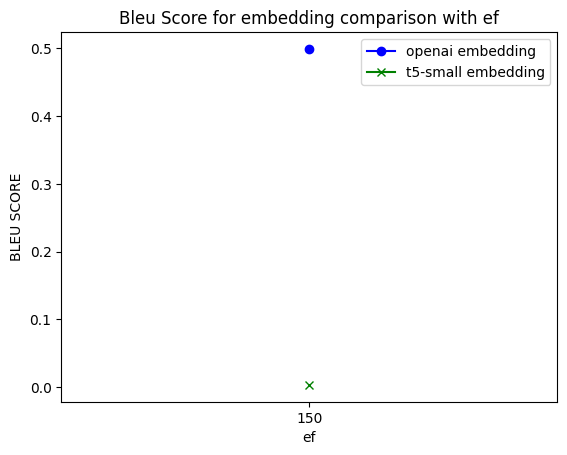

In [19]:
import matplotlib.pyplot as plt

# Plotting both lines on the same graph
plt.plot(efs, bleu_scores[0], label="openai embedding", color='blue', marker='o')  # First line
plt.plot(efs, bleu_scores[1], label="t5-small embedding", color='green', marker='x')  # Second line

plt.xticks(efs)

# Adding titles and labels
plt.title('Bleu Score for embedding comparison with ef')
plt.xlabel('ef')
plt.ylabel('BLEU SCORE')

# Showing legend
plt.legend()

# Displaying the plot
plt.show()


bleu score custom vector database

In [20]:
efs = list(range(150, 250, 100))
Ms = [16] * len(efs)

bleu_scores = []
for name, embeddings in embeddings_list:
    temp1_blue_scores = []
    for ef, M in zip(efs, Ms):
        rag = RAG(documents, embeddings)
        
        temp2_blue_scores = []
        # Using SmoothingFunction() to prevent zero BLEU score
        smooth = SmoothingFunction().method1
        for row in qa.itertuples():
            
            question, answer1, answer2, answer3 = row[1], row[2], row[3], row[4]
            references = [tokenize_text(answer1), tokenize_text(answer2), tokenize_text(answer3)]
            
            # Calculate BLEU score (use sentence_bleu for a single sentence)
            response = rag.response(question)
            candidate = tokenize_text(response)

            bleu_score = sentence_bleu(references, candidate, smoothing_function=smooth)
            temp2_blue_scores.append(bleu_score)
        average_bleu_score = sum(temp2_blue_scores)/len(temp2_blue_scores)
        temp1_blue_scores.append(average_bleu_score)
        print(f"average bleu score ({name}) (ef={ef}) (M={M}): {sum(temp2_blue_scores)/len(temp2_blue_scores)}")
    bleu_scores.append(temp1_blue_scores)

average bleu score (openai embeddings) (ef=150) (M=16): 0.5076517162085404
average bleu score (T5-small embeddings) (ef=150) (M=16): 0.0037533773870102967


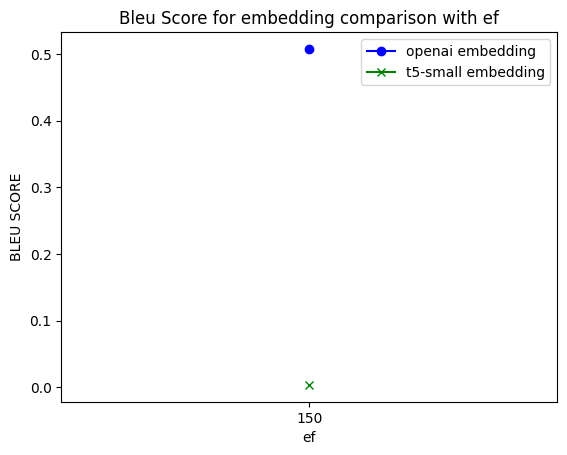

In [21]:
import matplotlib.pyplot as plt

# Plotting both lines on the same graph
plt.plot(efs, bleu_scores[0], label="openai embedding", color='blue', marker='o')  # First line
plt.plot(efs, bleu_scores[1], label="t5-small embedding", color='green', marker='x')  # Second line

plt.xticks(efs)

# Adding titles and labels
plt.title('Bleu Score for embedding comparison with ef')
plt.xlabel('ef')
plt.ylabel('BLEU SCORE')

# Showing legend
plt.legend()

# Displaying the plot
plt.show()
